# ML-Value-Investing 

#### Summary: look at all companies in the S&P 500 and try to predict whether or not it will beat the S&P. This will be done by first getting all the financial data from yahoo finance using the yahoo query library, then training a ML algorithm to predict weather or not the stock will beat the S&P in a year from the date the financial were published.

## get the data

### get S&P 500 Stocks

In [1]:
import pandas as pd

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table

In [4]:
df.head()

,Symbol,Security,SEC filings,GICS Sector,GICS Sub Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M Company,reports,Industrials,Industrial Conglomerates,"St. Paul, Minnesota",1976-08-09,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",1964-03-31,1800,1888
2,ABBV,AbbVie Inc.,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
3,ABMD,ABIOMED Inc,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",2018-05-31,815094,1981
4,ACN,Accenture plc,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [2]:
stocks = df['Symbol'].values

#### Get data from Yahoo Finance

In [7]:
from yahooquery import Ticker
from tqdm import tqdm
from datetime import date

balance_sheet_data = []
dates_and_names = {}
for stock_name in tqdm(stocks):
    try:
        stock = Ticker(stock_name)
        dates = []
        
        data = pd.concat([stock.balance_sheet().set_index('asOfDate'),
                stock.cash_flow().set_index('asOfDate'),
                stock.income_statement().set_index('asOfDate')],axis=1)
        if len(data) >3:
            data=data.fillna(0).select_dtypes(include=['float64']).pct_change()[1:-1].fillna(0)
            
            for i in data.index.values:
                i = pd.to_datetime(i)
                startDate = i.strftime('%Y-%m-%d')
                endDate = date(i.year + 1, i.month, i.day).strftime('%Y-%m-%d') 
                dates.append([startDate, endDate])
            dates_and_names[stock_name] = dates
            
            
            balance_sheet_data.append(data)
    except (AttributeError, ValueError):
        pass

100%|██████████| 505/505 [11:06<00:00,  1.32s/it]


In [8]:
def get_stock_preformance(stock,dates):
    """
    gets the stock preformance from the previouse year
    """
    data = Ticker(stock).history(start=dates[0],end=dates[1])
    return (data.iloc[-1].close - data.iloc[0].close)/ data.iloc[0].close

In [9]:
import numpy as np
returns = []
for i,j in tqdm(dates_and_names.items()):
    for date in j:
        try:
            returns.append(get_stock_preformance(i,date) - get_stock_preformance('spy',date))
            
        except AttributeError:
            returns.append(np.nan)

100%|██████████| 501/501 [07:57<00:00,  1.05it/s]


financial statements have pretty difrent atribute in them, but for this machine learning algorithm we will be only looking at the common atributes in all financial data

In [14]:

all_columns = []

for i in balance_sheet_data:
    all_columns.append(i.columns.values)

common_financials = all_columns[0]
for i in all_columns:
    common_financials = common_financials[np.in1d(common_financials,i)]

In [15]:
balance_sheet_data_clean = []
for i in balance_sheet_data:
    balance_sheet_data_clean.append(i[common_financials])

In [16]:
df = pd.concat(balance_sheet_data_clean)
df['returns'] = returns
df = df.dropna(subset=['returns'])
df.replace(-np.inf, 0, inplace=True)
df.replace(np.inf, 0, inplace=True)
df.dropna(inplace=True)
df.head()

,CapitalStock,CommonStock,CommonStockEquity,InvestedCapital,NetTangibleAssets,OrdinarySharesNumber,ShareIssued,StockholdersEquity,TangibleBookValue,TotalAssets,...,NetIncomeFromContinuingAndDiscontinuedOperation,NetIncomeFromContinuingOperationNetMinorityInterest,NetIncomeIncludingNoncontrollingInterests,NormalizedIncome,OperatingRevenue,PretaxIncome,TaxEffectOfUnusualItems,TaxRateForCalcs,TotalRevenue,returns
asOfDate,,,,,,,,,,,,,,,,,,,,,
2017-12-31,0.000000,0.000000,0.122839,0.162384,0.587542,-0.003087,0.005046,0.122839,0.587542,0.154410,...,-0.038020,-0.038020,-0.037367,-0.112865,0.051413,0.070183,0.000000,0.254417,0.051413,-0.118151
2018-12-31,0.000000,0.000000,-0.152815,-0.042882,0.544008,-0.030778,0.000000,-0.152815,0.544008,-0.039145,...,0.101070,0.101070,0.101458,0.100439,0.035000,-0.072602,-0.384714,-0.340845,0.035000,-0.361933
2019-12-31,0.000000,0.000000,0.027256,0.244000,2.351648,-0.002411,0.000000,0.027256,2.351648,0.223534,...,-0.145635,-0.145635,-0.145627,-0.065213,-0.019197,-0.184000,-1.074251,-0.153846,-0.019197,-0.105039
2017-12-31,0.781377,0.781377,0.504382,0.382592,-2.755171,0.183814,0.151354,0.504382,-2.755171,0.447803,...,-0.659286,-0.667921,-0.659286,-0.768262,0.313480,0.578910,-1.110785,0.612903,0.313480,0.287427
2018-12-31,0.013186,0.013186,-0.012072,-0.148433,-0.200329,0.006892,0.002686,-0.012072,-0.200329,-0.119043,...,3.964361,5.611898,3.964361,6.493506,0.043556,0.287763,-3.695588,-0.530000,0.116393,-0.084676


In [42]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.05, random_state=42)


In [44]:
X_train = train_set.drop(['returns'],axis=1)
y_train = train_set['returns']

X_test = test_set.drop(['returns'],axis=1)
y_test_returns = test_set['returns']

In [45]:
y_train = np.where(y_train.values > 0,1,0)
y_test = np.where(y_test_returns.values > 0,1,0)

In [46]:
# base rate
1 - sum(y_train) / len(y_train)

0.5798090040927695

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale",probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [47]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression 0.5384615384615384
RandomForestClassifier 0.6025641025641025
SVC 0.5256410256410257


/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


VotingClassifier 0.5256410256410257


In [48]:
most_imp = {}

for i,j in zip(common_financials,rnd_clf.feature_importances_):
    most_imp[i] = j


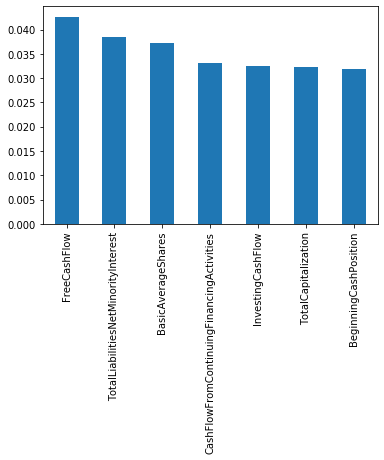

In [49]:
import collections

sorted_x = sorted(most_imp.items(), key=lambda kv: kv[1],reverse=True)
sorted_dict = collections.OrderedDict(sorted_x)

pd.Series(sorted_dict)[:7].plot.bar()

In [50]:
from sklearn.metrics import confusion_matrix
y_pred = rnd_clf.predict(X_test)

In [51]:
confusion_matrix(y_test,y_pred)

array([[35,  6],
       [25, 12]])

In [54]:
y_proba = rnd_clf.predict_proba(X_test)
preformance = []
for i in np.argwhere(np.where(y_proba>.55,1,0)[:,1:]>0)[:,:1]:
    preformance.append(y_test_returns.iloc[i].values)

In [55]:
np.mean(preformance)

0.07634303841816387

In [56]:
preformance

[array([0.04178793]),
 array([-0.24108976]),
 array([0.27241363]),
 array([1.18114123]),
 array([-0.21661117]),
 array([-0.19067571]),
 array([-0.27263807]),
 array([0.15570089]),
 array([0.04633371]),
 array([0.05199209]),
 array([0.01141864])]

## conclusion
this model beat the S&P 500 by 7%, one could use this model to make a long short strategy and short the S&P while buying the stocks this model predicts.